# Quantify Flakes

One of the key perfomance indicators that we would like to create greater visbility into and track over time is overall number and percent of flakes that occur. Individual test runs are flagged a "flake" if they are run mulitple times with a mix of passes and failes without any changes to the code being tested. Although they occur for individual test runs, there are a number of aggregate views that developers may want to look at to assess the overall health of thier project or testing platform. For Example:

* percent flakes on platform each day
* percent flakes by tab each week
* percent flakes by grid each month
* percent flakes by test overall (this can also be seen as a severity level = overall flake rate of test)

In order to provide maxium flexibility for the end-user of this work, instead of creating a number of dataframes to answer each of these specifc questions, we will define a long and narrow data structure (a list of tuples saved as a csv for now) that contains only 5 columns ("timestamp", "tab","grid","test","flake"). This allows superset (or pandas) to perform the last filter and/or aggreagtion of interest to an end user. Which is to say, there may appear to be a lot of repetion within the final dataset, but each row should be unique, and it should provide the simpelest useability for an end-user.    


In [1]:
import json
import gzip
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


from ipynb.fs.defs.metric_template import testgrid_labelwise_encoding
from ipynb.fs.defs.metric_template import CephCommunication
from ipynb.fs.defs.metric_template import save_to_disk, read_from_disk
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

True

In [2]:
## Specify variables
METRIC_NAME = "number_of_flakes"
# Specify the path for input grid data,
INPUT_DATA_PATH = "../../../../data/raw/testgrid_810.json.gz"

# Specify the path for output metric data
OUTPUT_DATA_PATH = f"../../../../data/processed/metrics/{METRIC_NAME}"

# Specify whether or not we are running this as a notebook or part of an automation pipeline.
AUTOMATION = os.getenv("IN_AUTOMATION")

## CEPH Bucket variables
## Create a .env file on your local with the correct configs,
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")
s3_input_data_path = "raw_data"
metric_path = f"metrics/{METRIC_NAME}"

In [3]:
## Import data
timestamp = datetime.datetime.today()

if AUTOMATION:
    filename = f"testgrid_{timestamp.day}{timestamp.month}.json"
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    s3_object = cc.s3_resource.Object(s3_bucket, f"{s3_input_data_path}/{filename}")
    file_content = s3_object.get()["Body"].read().decode("utf-8")
    testgrid_data = json.loads(file_content)

else:
    with gzip.open(INPUT_DATA_PATH, "rb") as read_file:
        testgrid_data = json.load(read_file)

## Calculation
- In this section, we calculate the metric values from the data.

In [4]:
unrolled_list = testgrid_labelwise_encoding(testgrid_data, 13)

In [5]:
# Convert to dataframe
df = pd.DataFrame(
    unrolled_list,
    columns=["timestamp", "tab", "grid", "test", "test_duration", "flake"],
)
df.head()

,timestamp,tab,grid,test,test_duration,flake
0,2021-04-14 16:12:04,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.583333,False
1,2021-04-14 15:05:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.216667,False
2,2021-04-14 13:13:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,99.100000,False
3,2021-04-14 02:02:46,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,107.316667,False
4,2021-04-13 19:12:42,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.583333,False


### Flake Severity Metric 
Some tests would be flaky for a lot of builds and thus have a high flake rate or severity. This metric can be leveraged to help prioritize the work needed to resolve the flake issues.

In [6]:
df_flake_severity = df[["test", "flake"]]
df_flake_severity.describe()

,test,flake
count,29292485,29292485
unique,14621,2
top,Overall,False
freq,40223,29175244


In [7]:
## The following metric implements flake severity
## or flake rate by tests
## Moving forward, this will be aggregated in Superset
## For the sake of completeness, it is implmented here
flake_severity = df.groupby("test").flake.mean().reset_index()
flake_severity.rename(columns={"flake": "flake_severity"}, inplace=True)
flake_severity

,test,flake_severity
0,Add Secret to Workloads.Add Secret to Workload...,0.0
1,Add Secret to Workloads.Add Secret to Workload...,0.0
2,Alertmanager: Configuration.creates a receiver...,0.0
3,Alertmanager: Configuration.deletes a receiver...,0.0
4,Alertmanager: Configuration.displays the Alert...,0.0
...,...,...
14616,user.openshift.io~v1~Group.Kubernetes resource...,0.0
14617,user.openshift.io~v1~Group.Kubernetes resource...,0.0
14618,user.openshift.io~v1~Group.Kubernetes resource...,0.0
14619,user.openshift.io~v1~Group.Kubernetes resource...,0.0


## Visualization 
- Here, we provide a quick visualization of the computed metric.

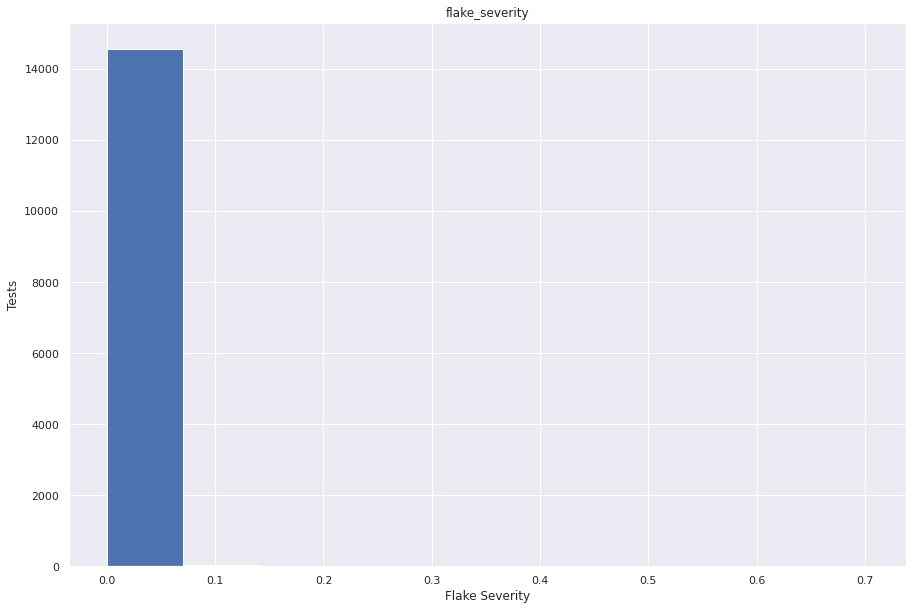

In [8]:
sns.set(rc={"figure.figsize": (15, 10)})
flake_severity.hist()
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.show()

From the above graph we can conclude that most of the tests have very low(~0) flake severity. One might look at this graph and assume that almost all of the tests have flake severity as 0. So, to get more clarity we have plotted another graph and here we've gone from about 8,000 tests to investigate for probable flakiness to less than 100. 

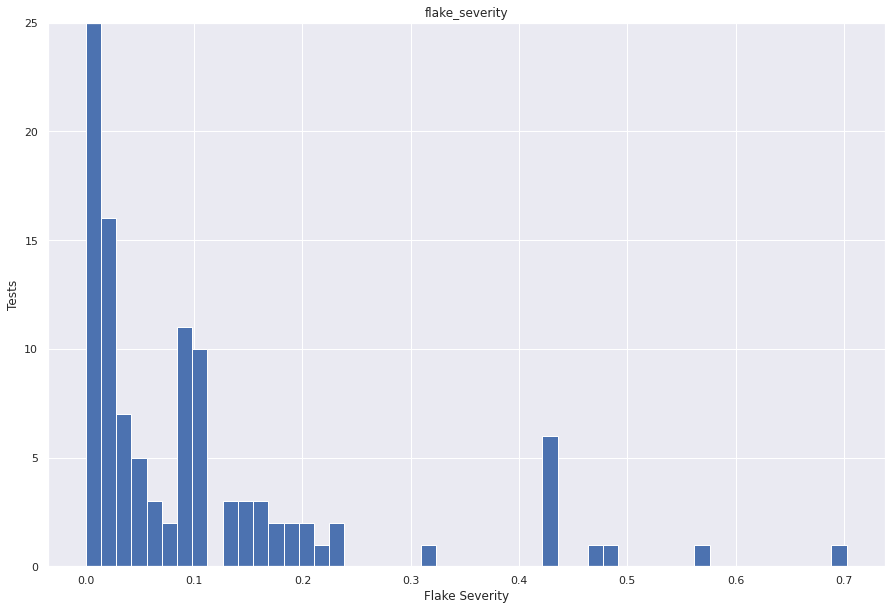

In [9]:
sns.set(rc={"figure.figsize": (15, 10)})
flake_severity.hist(bins=50)
plt.ylabel("Tests")
plt.xlabel("Flake Severity")
plt.ylim((0, 25))
plt.show()

From the above graph we can see that there are other values of flake severity for some tests. However it is a small bunch of tests that show a different set of flake severity. Let's see some tests that have a high flake severity score.

The top 5 tests with the highest flake score :

In [10]:
flake_severity.nlargest(5, "flake_severity")

,test,flake_severity
5359,openshift-tests.[sig-arch] Monitor cluster whi...,0.702483
211,Cluster upgrade.[sig-imageregistry] Image regi...,0.573415
217,Cluster upgrade.[sig-network-edge] Cluster fro...,0.483348
215,Cluster upgrade.[sig-network-edge] Application...,0.476019
184,Cluster upgrade.[sig-api-machinery] Kubernetes...,0.430634


In [11]:
# Overall flake percentage
df.flake.sum() / df.flake.count()

0.00400242587817319

### Save results to Ceph or locally
* Use the following helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [12]:
filename = f"{METRIC_NAME}-{timestamp.year}-{timestamp.month}-{timestamp.day}.parquet"

if AUTOMATION == "True":
    cc = CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)
    cc.upload_to_ceph(df, metric_path, filename)
else:
    save_to_disk(df, OUTPUT_DATA_PATH, filename)

In [13]:
## Sanity check to see if the dataset is the same
if AUTOMATION == "True":
    sanity_check = cc.read_from_ceph(metric_path, filename)
else:
    sanity_check = read_from_disk(OUTPUT_DATA_PATH, filename)

sanity_check

,timestamp,tab,grid,test,test_duration,flake
0,2021-04-14 16:12:04,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,105.583333,False
1,2021-04-14 15:05:09,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,87.216667,False
2,2021-04-14 13:13:36,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,99.100000,False
3,2021-04-14 02:02:46,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,107.316667,False
4,2021-04-13 19:12:42,"""redhat-assisted-installer""",periodic-ci-openshift-release-master-nightly-4...,Overall,85.583333,False
...,...,...,...,...,...,...
29292480,2021-04-04 00:00:53,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,openshift-tests.[sig-arch] Monitor cluster whi...,NaN,False
29292481,2021-04-03 00:01:26,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,openshift-tests.[sig-arch] Monitor cluster whi...,NaN,False
29292482,2021-04-02 00:00:37,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,openshift-tests.[sig-arch] Monitor cluster whi...,NaN,True
29292483,2021-04-01 00:01:05,"""redhat-single-node""",periodic-ci-openshift-release-master-nightly-4...,openshift-tests.[sig-arch] Monitor cluster whi...,NaN,False


### Conclusion
This notebook computed number of flakes and the flake severity metric. The dataframe saved on ceph can be used to generate aggregated views and visualizations.